In [ ]:
#https://cloud.google.com/community/tutorials/bigquery-ibis
!pip install --upgrade "git+https://github.com/ibis-project/ibis.git#egg=ibis_framework[bigquery]"

In [1]:
#https://googleapis.dev/python/bigquery/latest/index.html
import ibis
import os
import pandas
import datetime
import geopandas

from google.cloud import bigquery

CREDENTIAL = "./gcp-credential.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'{CREDENTIAL}'

"""This way doesn't work - just use separate JSON and call it instead of putting into .env
credentials = service_account.Credentials.from_service_account_file(
    f"{CREDENTIAL}", scopes = ["https://www.googleapis.com/auth/cloud-platform"]
)
"""
client = bigquery.Client()

# Do we have to authenticate our credentials first?

# Use ibis to construct SQL query
conn = ibis.bigquery.connect(
    project_id = 'ita-datalakepoc',
    dataset_id = 'publicwork_311'
)

""" OR, this also works
conn = ibis.bigquery.connect(
    dataset_id='ita-datalakepoc.publicwork_311')
"""

table = conn.table('ServiceRequestTopLevel')

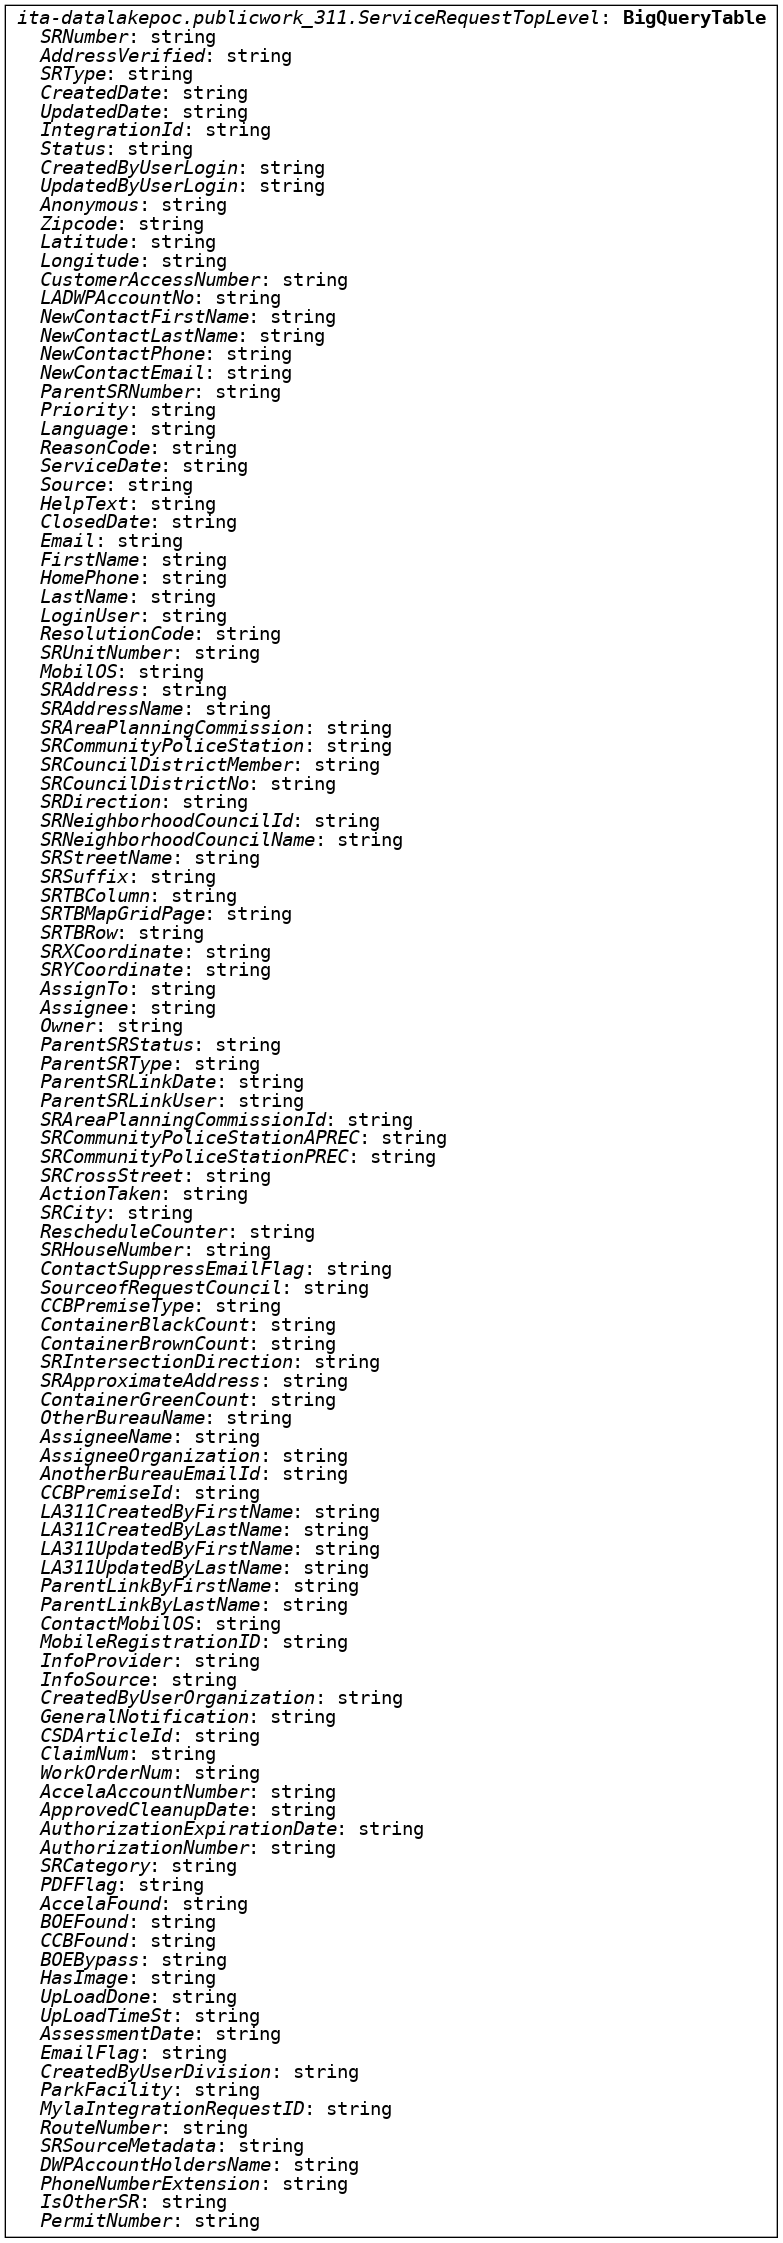

In [2]:
table

In [3]:
# First, just subset the columns down
keep_cols = ["SRNumber", "SRType", "CreatedDate", "Longitude", "Latitude"]
expr = table[keep_cols]

# There seems to be a date issue with ibis
# Instead of casting it as a date, let's keep date as a string
# Parse the string instead
# We'll keep up to the last 2 year's of data and use pandas to further subset
current_year = datetime.datetime.today().year
prior_year = current_year - 1

expr2 = expr[(expr.CreatedDate.contains(str(current_year))) | 
             (expr.CreatedDate.contains(str(prior_year)))]

# Remove specific request types
expr3 = expr2[expr2.SRType != "Homeless Encampment"]


In [4]:
# Compile shows the SQL statement
print(ibis.bigquery.compile(expr3.limit(10)))

SELECT *
FROM (
  SELECT `SRNumber`, `SRType`, `CreatedDate`, `Longitude`, `Latitude`
  FROM `ita-datalakepoc.publicwork_311.ServiceRequestTopLevel`
  WHERE (STRPOS(`CreatedDate`, '2021') - 1 >= 0) OR (STRPOS(`CreatedDate`, '2020') - 1 >= 0)
) t0
WHERE `SRType` != 'Homeless Encampment'
LIMIT 10


In [5]:
print(expr3.execute(limit=10))

       SRNumber                          SRType          CreatedDate  \
0  1-1893881531  Pothole - Small Asphalt Repair  03/11/2021 16:00:09   
1  1-1888644151                     Bulky Items  03/05/2021 12:51:59   
2  1-1892937841                     Bulky Items  03/10/2021 16:28:27   
3  1-1893598881                     Bulky Items  03/11/2021 12:42:17   
4  1-1893533181                     Bulky Items  03/11/2021 11:51:49   
5  1-1894532521                     Bulky Items  03/12/2021 12:19:09   
6  1-1890872721                     Bulky Items  03/08/2021 17:48:51   
7  1-1889993031                     Bulky Items  03/08/2021 08:30:17   
8  1-1893756521                     Bulky Items  03/11/2021 14:31:09   
9  1-1893796931                     Bulky Items  03/11/2021 14:57:58   

        Longitude       Latitude  
0  -118.281678668  33.9709382399  
1  -118.278827935    33.93273966  
2  -118.431099648  34.3050655161  
3  -118.421172074  34.2973926921  
4   -118.46106378  34.2993206755

In [6]:
df = expr3.execute(limit=None)

In [ ]:
# Try the SQL statement instead?
QUERY = (
    """
    SELECT `SRNumber`, `SRType`, CAST(`CreatedDate` AS DATE) AS `CreatedDate`,
       `Longitude`, `Latitude`
    FROM `ita-datalakepoc.publicwork_311.ServiceRequestTopLevel`
    LIMIT 20
    """
)

query_job = client.query(QUERY)
df = query_job.to_dataframe()
df.head()
